Total WAV files found: 28539


Processing Audio Files:   0%|                                                                | 0/28539 [00:00<?, ?it/s]C:\Users\opsb2\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\opsb2\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\opsb2\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
Processing Audio Files: 100%|██████████████████████████████████████████████████| 2

                                    file_path  duration  sampling_rate
0  C:\LibriSpeech\processed\103-1240-0000.wav    13.696          16000
1  C:\LibriSpeech\processed\103-1240-0001.wav    15.616          16000
2  C:\LibriSpeech\processed\103-1240-0002.wav    13.472          16000
3  C:\LibriSpeech\processed\103-1240-0003.wav    14.240          16000
4  C:\LibriSpeech\processed\103-1240-0004.wav    12.096          16000

Dataset Summary:
           duration  sampling_rate
count  28539.000000        28539.0
mean      12.069934        16000.0
std        3.569181            0.0
min        0.704000        16000.0
25%       10.944000        16000.0
50%       13.344000        16000.0
75%       14.560000        16000.0
max       24.032000        16000.0


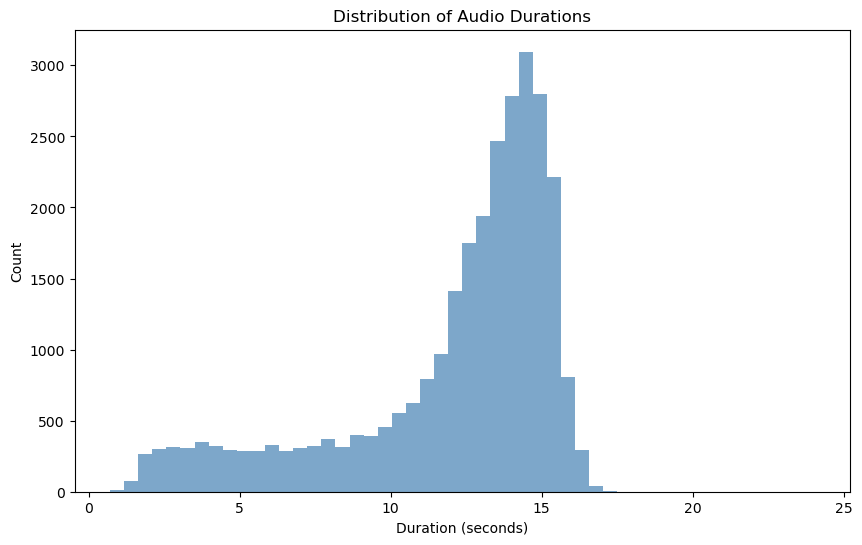

In [ ]:
!pip install noisereduce

import os
import librosa
import soundfile as sf
import numpy as np
import pandas as pd
from tqdm import tqdm
import noisereduce as nr
import matplotlib.pyplot as plt


data_dir = r"C:\LibriSpeech\train-clean-100"
processed_dir = r"C:\LibriSpeech\processed"  
os.makedirs(processed_dir, exist_ok=True)


wav_files = [
    os.path.join(root, file)
    for root, _, files in os.walk(data_dir)
    for file in files if file.lower().endswith(".wav")
]
print(f"Total WAV files found: {len(wav_files)}")

def preprocess_audio(file_path, output_dir):
    try:
        
        y, sr = librosa.load(file_path, sr=16000, mono=True)
        
        
        y, _ = librosa.effects.trim(y, top_db=20)
        
        
        y = nr.reduce_noise(y=y, sr=sr)
        
        
        y = librosa.util.normalize(y)
        
        
        output_path = os.path.join(output_dir, os.path.basename(file_path))
        sf.write(output_path, y, sr)
        
        return {
            "file_path": output_path,
            "duration": librosa.get_duration(y=y, sr=sr),
            "sampling_rate": sr,
        }
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


metadata_list = []
for file in tqdm(wav_files, desc="Processing Audio Files"):
    result = preprocess_audio(file, processed_dir)
    if result:
        metadata_list.append(result)


df = pd.DataFrame(metadata_list)
df.to_csv("processed_metadata.csv", index=False)


print(df.head())
print("\nDataset Summary:")
print(df.describe())

# Plot Duration Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['duration'], bins=50, color='steelblue', alpha=0.7)
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Distribution of Audio Durations")
plt.show()


In [ ]:
#conversion to wav format

Original duration: 13.70 sec
After VAD (aggressiveness=1): 11.67 sec
After VAD (aggressiveness=2): 10.95 sec


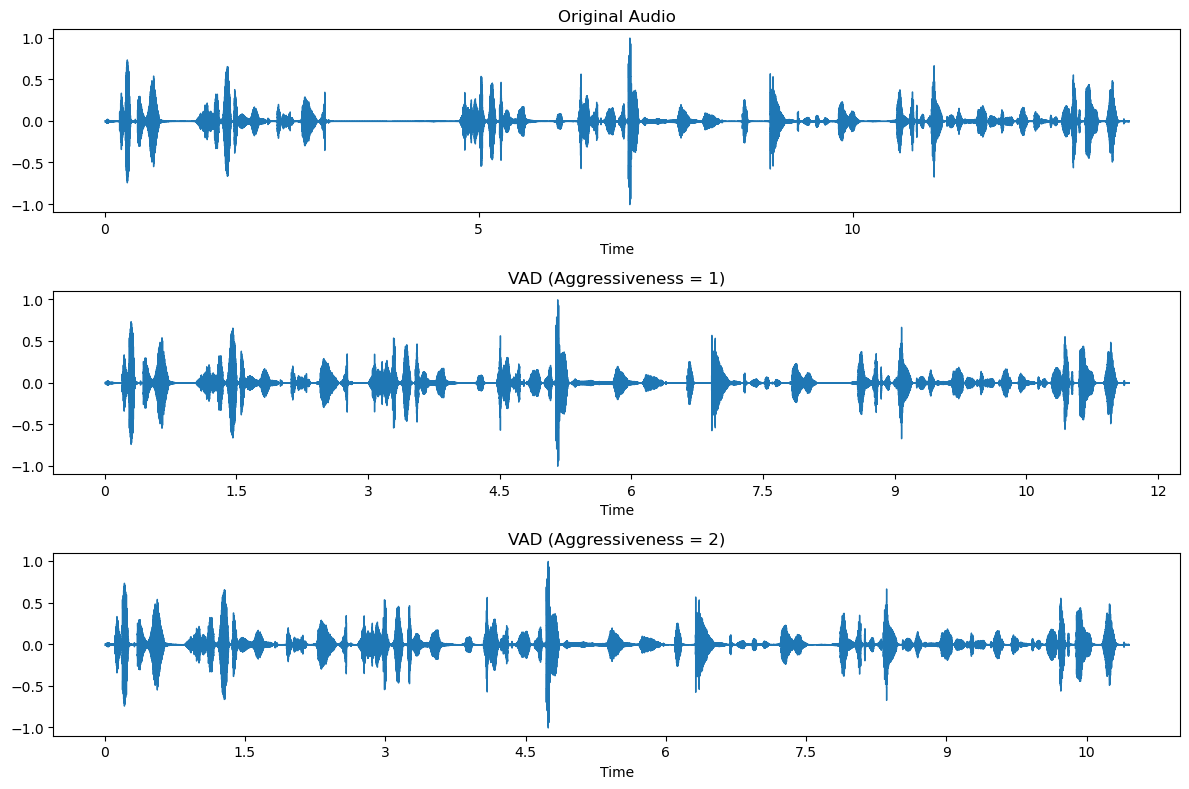

Playing Original Audio:


Playing VAD Audio (Aggressiveness = 1):


Playing VAD Audio (Aggressiveness = 2):


In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import webrtcvad
import struct
from IPython.display import Audio, display

def float_to_pcm16(waveform):
    """Convert float waveform (-1 to 1) to 16-bit PCM format."""
    waveform_int16 = np.int16(waveform * 32768)  
    return waveform_int16.tobytes()

def remove_silence_vad(y, sr, aggressiveness=1):
    """Removes non-speech frames using WebRTC VAD."""
    vad = webrtcvad.Vad(aggressiveness)
    frame_ms = 30  
    frame_length = int(sr * (frame_ms / 1000))  

   
    frames = [y[i: i + frame_length] for i in range(0, len(y) - frame_length, frame_length)]
    
    
    pcm_frames = [float_to_pcm16(frame) for frame in frames]
    
   
    voiced_frames = [frames[i] for i in range(len(frames)) if vad.is_speech(pcm_frames[i], sr)]
    
    return np.concatenate(voiced_frames, axis=0) if voiced_frames else y


file_path = r"C:\LibriSpeech\processed\103-1240-0000.wav"  
y, sr = librosa.load(file_path, sr=16000, mono=True)


y_vad_level1 = remove_silence_vad(y, sr, aggressiveness=1)
y_vad_level2 = remove_silence_vad(y, sr, aggressiveness=2)


print(f"Original duration: {librosa.get_duration(y=y, sr=sr):.2f} sec")
print(f"After VAD (aggressiveness=1): {librosa.get_duration(y=y_vad_level1, sr=sr):.2f} sec")
print(f"After VAD (aggressiveness=2): {librosa.get_duration(y=y_vad_level2, sr=sr):.2f} sec")


plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title("Original Audio")

plt.subplot(3, 1, 2)
librosa.display.waveshow(y_vad_level1, sr=sr)
plt.title("VAD (Aggressiveness = 1)")

plt.subplot(3, 1, 3)
librosa.display.waveshow(y_vad_level2, sr=sr)
plt.title("VAD (Aggressiveness = 2)")

plt.tight_layout()
plt.show()


print("Playing Original Audio:")
display(Audio(y, rate=sr))

print("Playing VAD Audio (Aggressiveness = 1):")
display(Audio(y_vad_level1, rate=sr))

print("Playing VAD Audio (Aggressiveness = 2):")
display(Audio(y_vad_level2, rate=sr))


In [ ]:
import os
import numpy as np
import librosa
import webrtcvad
import soundfile as sf


processed_input_dir = r"C:\LibriSpeech\processed"  
output_vad_dir = r"C:\LibriSpeech\processed_vad"  
os.makedirs(output_vad_dir, exist_ok=True)

def float_to_pcm16(waveform):
    """Convert float waveform (-1 to 1) to 16-bit PCM format."""
    return np.int16(waveform * 32768)

def remove_silence_vad(y, sr, aggressiveness=2):  
    """Removes non-speech frames using WebRTC VAD."""
    vad = webrtcvad.Vad(aggressiveness)
    frame_ms = 30  
    frame_length = int(sr * (frame_ms / 1000))  

    
    frames = [y[i: i + frame_length] for i in range(0, len(y) - frame_length, frame_length)]
    
    
    pcm_frames = [float_to_pcm16(frame).tobytes() for frame in frames]
    
    
    voiced_frames = [frames[i] for i in range(len(frames)) if vad.is_speech(pcm_frames[i], sr)]
    
    return np.concatenate(voiced_frames, axis=0) if voiced_frames else y

def process_audio(file_path, output_dir):
    """Load, convert to PCM 16-bit, apply VAD (Level 2), and save."""
    try:
        
        y, sr = librosa.load(file_path, sr=16000, mono=True)

        
        y_pcm16 = float_to_pcm16(y)

        
        y_vad = remove_silence_vad(y_pcm16, sr, aggressiveness=2)

        
        y_vad_float = y_vad.astype(np.float32) / 32768.0  

        
        relative_path = os.path.relpath(file_path, processed_input_dir)
        output_file_path = os.path.join(output_dir, relative_path)

       
        os.makedirs(os.path.dirname(output_file_path), exist_ok=True)

        
        sf.write(output_file_path, y_vad_float, sr, subtype="PCM_16")

    except Exception as e:
        print(f"Error processing {file_path}: {e}")


wav_files = [
    os.path.join(root, file)
    for root, _, files in os.walk(processed_input_dir)
    for file in files if file.lower().endswith(".wav")
]


for i, file in enumerate(wav_files):
    print(f"Processing {i+1}/{len(wav_files)}: {file}")
    process_audio(file, output_vad_dir)

print(f"✅ Processed {len(wav_files)} files with VAD (Aggressiveness = 2) and saved in '{output_vad_dir}'.")


Processing 1/28539: C:\LibriSpeech\processed\103-1240-0000.wav
Processing 2/28539: C:\LibriSpeech\processed\103-1240-0001.wav
Processing 3/28539: C:\LibriSpeech\processed\103-1240-0002.wav
Processing 4/28539: C:\LibriSpeech\processed\103-1240-0003.wav
Processing 5/28539: C:\LibriSpeech\processed\103-1240-0004.wav
Processing 6/28539: C:\LibriSpeech\processed\103-1240-0005.wav
Processing 7/28539: C:\LibriSpeech\processed\103-1240-0006.wav
Processing 8/28539: C:\LibriSpeech\processed\103-1240-0007.wav
Processing 9/28539: C:\LibriSpeech\processed\103-1240-0008.wav
Processing 10/28539: C:\LibriSpeech\processed\103-1240-0009.wav
Processing 11/28539: C:\LibriSpeech\processed\103-1240-0010.wav
Processing 12/28539: C:\LibriSpeech\processed\103-1240-0011.wav
Processing 13/28539: C:\LibriSpeech\processed\103-1240-0012.wav
Processing 14/28539: C:\LibriSpeech\processed\103-1240-0013.wav
Processing 15/28539: C:\LibriSpeech\processed\103-1240-0014.wav
Processing 16/28539: C:\LibriSpeech\processed\103

In [ ]:
from collections import defaultdict

speaker_durations = defaultdict(lambda: {"original": 0, "vad": 0})

for root, _, files in os.walk(original_dir):
    for file in files:
        if file.endswith(".wav"):
            orig_path = os.path.join(root, file)
            vad_path = os.path.join(vad_dir, os.path.relpath(orig_path, original_dir))

            speaker = orig_path.split(os.sep)[-3]  

            
            y_orig, sr_orig = librosa.load(orig_path, sr=16000)
            y_vad, sr_vad = librosa.load(vad_path, sr=16000)

            
            speaker_durations[speaker]["original"] += librosa.get_duration(y=y_orig, sr=sr_orig)
            speaker_durations[speaker]["vad"] += librosa.get_duration(y=y_vad, sr=sr_vad)


speakers = list(speaker_durations.keys())
orig_durations = [speaker_durations[s]["original"] for s in speakers]
vad_durations = [speaker_durations[s]["vad"] for s in speakers]


plt.figure(figsize=(15, 6))
plt.bar(speakers, orig_durations, alpha=0.6, label="Original", color="blue")
plt.bar(speakers, vad_durations, alpha=0.6, label="VAD", color="red")
plt.xlabel("Speaker ID")
plt.ylabel("Total Duration (seconds)")
plt.xticks(rotation=90)
plt.legend()
plt.title("Total Duration Per Speaker Before & After VAD")
plt.show()


C:\Users\opsb2\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\opsb2\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\opsb2\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


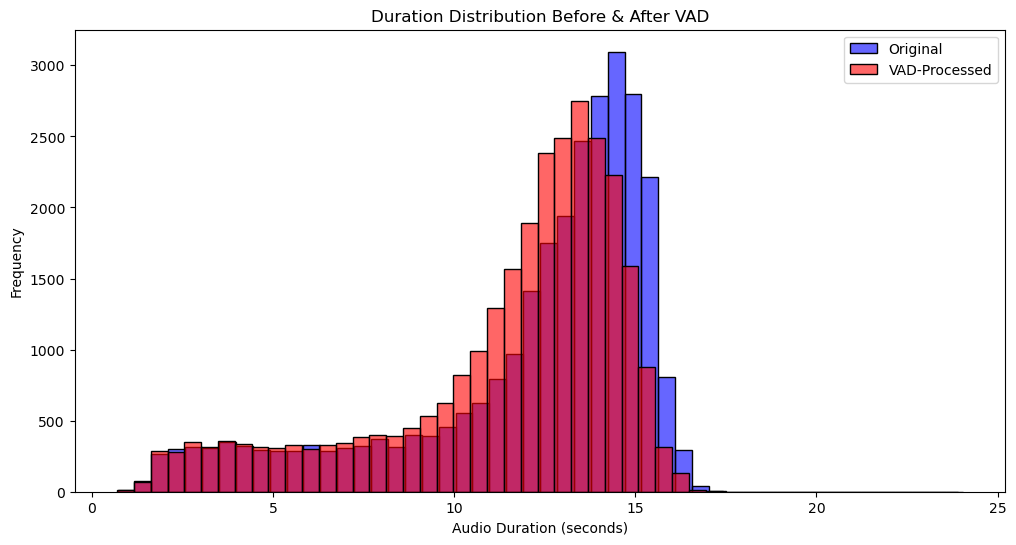

In [ ]:
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import seaborn as sns

original_dir = r"C:\LibriSpeech\processed"
vad_dir = r"C:\LibriSpeech\processed_vad"

original_durations = []
vad_durations = []

for root, _, files in os.walk(original_dir):
    for file in files:
        if file.endswith(".wav"):
            orig_path = os.path.join(root, file)
            vad_path = os.path.join(vad_dir, os.path.relpath(orig_path, original_dir))

            
            y_orig, sr_orig = librosa.load(orig_path, sr=16000)
            y_vad, sr_vad = librosa.load(vad_path, sr=16000)

            
            original_durations.append(librosa.get_duration(y=y_orig, sr=sr_orig))
            vad_durations.append(librosa.get_duration(y=y_vad, sr=sr_vad))

# Plot distributions
plt.figure(figsize=(12, 6))
sns.histplot(original_durations, bins=50, color="blue", alpha=0.6, label="Original")
sns.histplot(vad_durations, bins=50, color="red", alpha=0.6, label="VAD-Processed")
plt.xlabel("Audio Duration (seconds)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Duration Distribution Before & After VAD")
plt.show()
